# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

*Загрузим необходимые библиотеки для работы*

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')

*Загрузим исходные датасеты*

In [2]:
pd.options.display.max_columns = 100
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
df_full.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

*Оценим размеры датасетов*

In [4]:
df_full.shape, df_train.shape, df_test.shape

((22716, 87), (16860, 87), (5856, 53))

*Мы видим, что в датасете df_test сильно меньше признаков, чем в df_train.*

*Давайте оценим, каких именно столцов нет в df_test, которые есть в df_train:*

In [5]:
columns_not_in_df_test = set(df_train.columns) - set(df_test.columns)
columns_not_in_df_test

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

*По типам отсутствующих признаков, мы видим, что в df_test отсутствуют признаки, относящиеся к выходам из процессов обработки сырья/дальнейшей фракции, что объяснимо. Именно данные признаки мы и будем предсказывать в нашем проекте в будущем.*

***

*Проверим данные на пропуски и попробуем их обработать*

In [6]:
df_train.isna().sum().sort_values(ascending=False).head(10)

rougher.output.recovery               2573
rougher.output.tail_ag                2250
rougher.output.tail_sol               2249
rougher.output.tail_au                2249
secondary_cleaner.output.tail_sol     1986
rougher.input.floatbank11_xanthate    1904
final.output.recovery                 1521
primary_cleaner.input.sulfate         1307
primary_cleaner.input.depressant      1262
rougher.calculation.au_pb_ratio       1242
dtype: int64

In [7]:
print("Процент пропусков во всем датасете: {:.1%}".format(df_train.isna().sum().sum() / (df_train.shape[0] * df_train.shape[1])))

Процент пропусков во всем датасете: 2.1%


In [8]:
df_test.isna().sum().sort_values(ascending=False).head(10)

rougher.input.floatbank11_xanthate          353
primary_cleaner.input.sulfate               302
primary_cleaner.input.depressant            284
rougher.input.floatbank10_sulfate           257
primary_cleaner.input.xanthate              166
rougher.input.floatbank10_xanthate          123
rougher.input.feed_sol                       67
rougher.input.floatbank11_sulfate            55
rougher.input.feed_rate                      40
secondary_cleaner.state.floatbank3_a_air     34
dtype: int64

In [9]:
print("Процент пропусков во всем датасете: {:.1%}".format(df_test.isna().sum().sum() / (df_test.shape[0] * df_test.shape[1])))

Процент пропусков во всем датасете: 0.8%


*Видим что в обучающем датасете пропусков больше и они в целевых признаках, в тестовом датасете пропусков меньше.*

*Простовыбрасывать данные нет необходимости, так как мы знаем, что данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.*

*Поэтому для замены пропусков мы воспользуемся методом IterativeImputer из библиотеки sklearn*

***

*Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака.*

In [10]:
'''
Функция, которая на вход принимает три параметра:
C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.

А возвращает параметр Recovery (эффективность восстановления)
'''
def recovery(C, F, T):
    value = (((C * (F - T))) / (F * (C - T))) * 100
    #Так как мы не заполняли пропуски, то в значении F, может оказаться пропуск или 0, то наша функция выдаст
    #ошибочное значение, поэтому отсекем эти случаи (от -inf до +inf)
    #Так же данное решение обусловлено min/max значениями rougher.output.recovery, которые лежат от 0 до 100.
    value[value<0] = np.nan
    value[value>100] = np.nan
    return value

In [11]:
#Вытащим все необходимые переменные из данных
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
recovery_real = df_train['rougher.output.recovery']

In [12]:
#Откинем все NaN, для оценки среднеквадратичной ошибки
mean_squared_error(recovery_real.dropna(), recovery(C, F, T).dropna())

2.0435431534920925e-28

***

*Далее, для удобства дальнейшей работы с данными, приведем наши датасеты в единное пространство индексов, для этого индексируем наши данные по столбцу даты.*

*Это позволит нам в будущем, на этапе построения модели, брать необходимые данные из полного датасета, для анализа эффективности работы модели*

In [13]:
df_train.index = pd.DatetimeIndex(df_train['date'])
df_train = df_train.drop(['date'], axis=1)

df_test.index = pd.DatetimeIndex(df_test['date'])
df_test = df_test.drop(['date'], axis=1)

df_full.index = pd.DatetimeIndex(df_full['date'])
df_full = df_full.drop(['date'], axis=1)

***

*Обработаем пропуски в наших данных, для этого воспользуемся инструментом IterativeImputer из библиотеки sklearn*

In [14]:
#Сохраним имена признаков перед процедурой итеративного заполнения пропусков
df_train_columns = df_train.columns
df_test_columns = df_test.columns
df_full_columns = df_full.columns
df_train_index = df_train.index
df_test_index = df_test.index
df_full_index = df_full.index

#Применим итеративное заполнение пропусков
imp_mean = IterativeImputer(random_state=42)
df_train = pd.DataFrame(imp_mean.fit_transform(df_train))
df_test = pd.DataFrame(imp_mean.fit_transform(df_test))
df_full = pd.DataFrame(imp_mean.fit_transform(df_full))

#Восстановим имена признаков
df_train.columns = df_train_columns
df_test.columns = df_test_columns
df_full.columns = df_full_columns
df_train.index = df_train_index
df_test.index = df_test_index
df_full.index = df_full_index

In [15]:
#Проверим остались ли пропуски в наших данных
df_train.isna().sum().sum(), df_test.isna().sum().sum(), df_full.isna().sum().sum()

(0, 0, 0)

*Видим, что пропусков в наших данных нет*

### Вывод

 * *Мы выяснили, какие признаки отсутствуют в test, в основном это выходные параметры, которые мы и будем предсказывать, чтобы оценить адекватность нашей модели.*
 * *Так же мы посчитали среднеквадратичную ошибку на признаке rougher.output.recovery, которая оказалась ничтожно мала, из чего мы можем сделать вывод, что наша функция эффективности обогащения работает корректно.*
 * *Пропуски обработали с помощью IterativeImputer*

***

# 2. Анализ данных

#### *Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки*

In [16]:
#Создадим список из названия процессов производства
processes = ['rougher.input.feed_', 
             'rougher.output.concentrate_', 
             'primary_cleaner.output.concentrate_', 
             'final.output.concentrate_']

#Отдельно выделим тиы металлов, чтобы потом мерджить их с производственными процессами
metals = ['au', 'pb', 'ag']

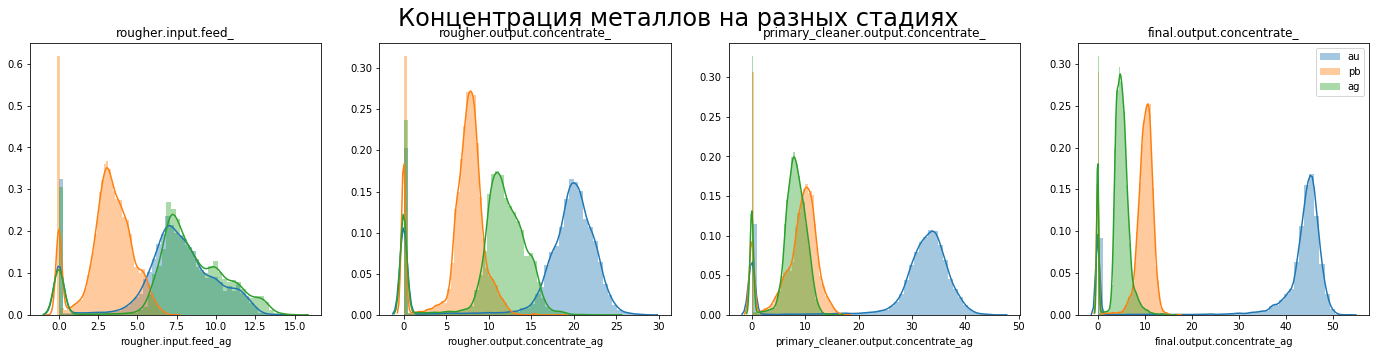

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(24,5)) 
fig.suptitle('Концентрация металлов на разных стадиях', fontsize=24);
for process, ax in zip(processes, axes):
    ax.set_title(process)
    for metal in metals:        
        columns = process+metal
        sns.distplot(df_train.loc[:, columns], label=metal, ax=ax)    
plt.legend(loc='best')
plt.show();

*По полученным данным мы видим, что при прохождении изначальной фракции по производственным цепочкам, концентрация золота значительно увеличивается*

***

#### *Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.*

In [18]:
#Сохраним размеры гранул в отдельные переменные
train_feed_size = df_train['rougher.input.feed_size']
test_feed_size = df_test['rougher.input.feed_size']

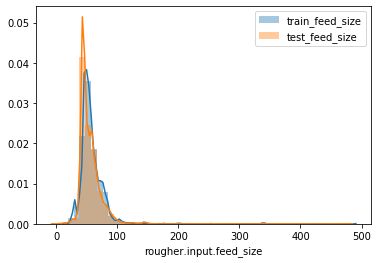

In [19]:
sns.distplot(train_feed_size, label='train_feed_size')
sns.distplot(test_feed_size, label='test_feed_size')
plt.legend();

*Визуально кажется, что распределения похожи.*

*Проверим гипотезу о равенстве двух средних генеральных совокупностей*

In [20]:
alpha = .01
results = st.ttest_ind(train_feed_size, test_feed_size)
if (results.pvalue < alpha):
    print("Распределения размеров гранул в двух выборках не отличаются")
else:
    print("Распределения размеров гранул в двух выборках отличаются")

Распределения размеров гранул в двух выборках не отличаются


***

#### *Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.*

In [21]:
def plot_sum_metal(train, test):
    fig, axes = plt.subplots(1, 4, figsize=(24,5)) 
    fig.suptitle('Суммарная концентрация металлов на разных стадиях', fontsize=26)
    summary_train_concentration = []
    summary_test_concentration = []
    for process, ax in zip(processes, axes):
        ax.set_title(process)
        summary_train_concentration = train[process+metals[0]] + train[process+metals[1]] + train[process+metals[2]]
        if process==processes[0]:
            summary_test_concentration = test[process+metals[0]] + test[process+metals[1]] + test[process+metals[2]]
            sns.distplot(summary_test_concentration, ax=ax) 
        sns.distplot(summary_train_concentration, ax=ax)
    plt.show()

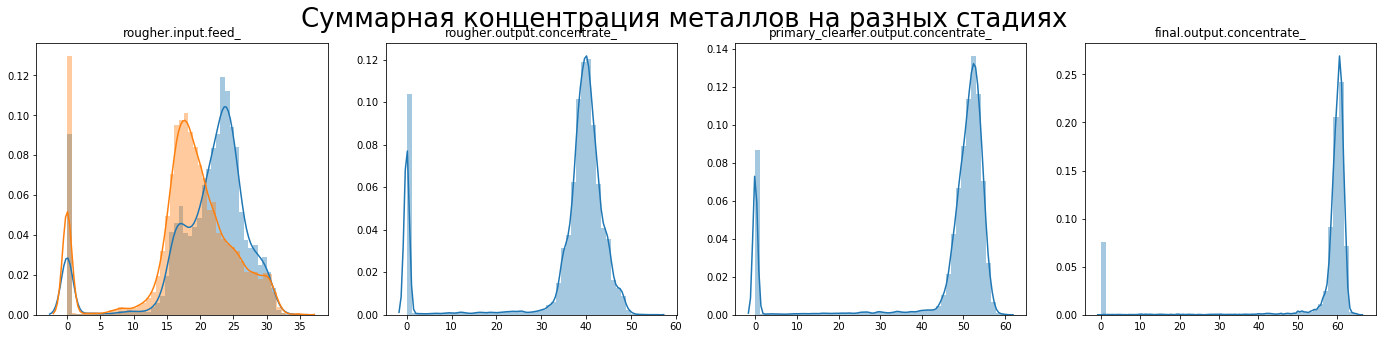

In [22]:
plot_sum_metal(df_train, df_test)

*При анализе суммарной концентрации металлов на разных стадиях, мы видим что имеется определнное количество нулевых значений. Предположительно, что данные нулевые значения появились в датасете из-за ложного срабатывания датчика.*

*Удалим из обучающей и тестовой выборки нулевые значения*

In [23]:
for process in processes:
    for metal in metals:
        df_train = df_train.loc[df_train[process+metal] != 0]
        if process==processes[0]:
            df_test = df_test.loc[df_test[process+metal] != 0]

*Посмотрим на получившиеся размеры датасетов*

In [24]:
df_train.shape, df_test.shape

((15076, 86), (5487, 52))

*Видим, что размеры сократились, давайте теперь посмотрим на  распределение суммарной концентрации металлов на разных этапах*

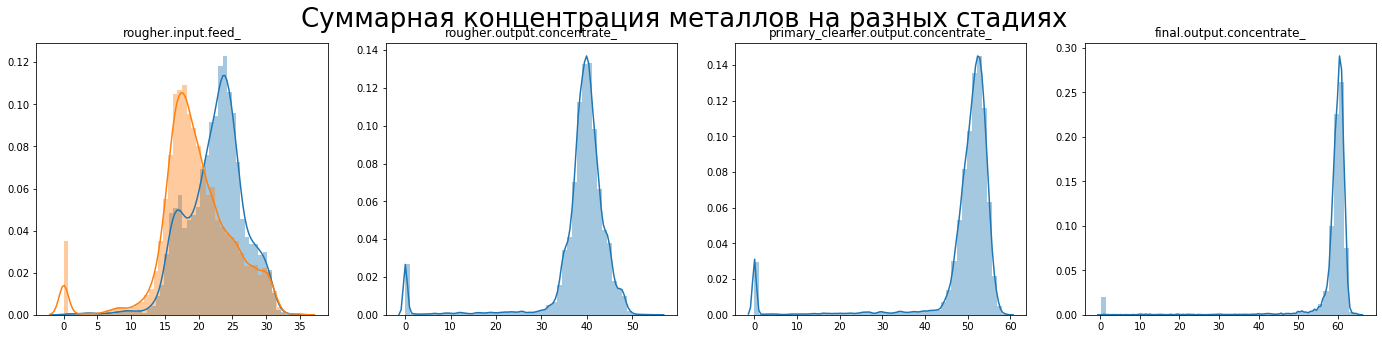

In [25]:
plot_sum_metal(df_train, df_test)

*Видим, что количество нулевых значений убавилось, но остались в датасете часть значений близких к 0, оставляем их, так как неизвестна их природа, возможно, они часть реального производственного процесса*

***
***

# 3. Модель

*Далее нам необходимо построить две модели, с помощью которых необходимо предсказать два признака:*
 * *эффективность обогащения чернового концентрата rougher.output.recovery*
 * *эффективность обогащения финального концентрата final.output.recovery*

*Чтобы вычислить эффективность обогащаения, мы воспользуемся функцией, котороую применяли выше, на вход которой необходимо подать следующие признаки:*
 * *output.concentrate_au*
 * *input.feed_au*
 * *output.tail_au*

*Далее мы понимаем, чтобы нам предсказать целевой признак rougher.output.recovery, мы должны обучится на признаках, которые относятся к этапу rougher, так как следующие производтвенные цепочки еще не были начаты/закончены. Будем предсказывать два целевых признака:*
 * *rougher.output.concentrate_au*
 * *rougher.output.tail_au*

*После нам необходимо будет предсказать целевой признак final.output.recovery, который мы будем предсказывать по признакам всех этапов, предшествующих этапу final, так как эти этапы уже прошли/завершены*

*Это означает что мы будем строить две модели с многоцелевой регрессией для двух целевых признаков каждая*

***

In [26]:
'''
Создадим наборы обучающей и тестовой выборки для предсказания rougher.output.recovery.
Для обучающей и тестовой выборки выберим все признаки содержащие rougher в df_test
'''
rougher_columns = df_test.loc[:, df_test.columns.str.contains('rougher')].columns

X_train_rougher = df_train[rougher_columns]
y_train_rougher = df_train[['rougher.output.concentrate_au', 'rougher.output.tail_au']]

X_test_rougher = df_test[rougher_columns]
y_test_rougher = df_full[['rougher.output.recovery']].query('index in @df_test.index')

*В случае с предсказанием final.output.recovery, мы будем предсказывать непосредственно целевую переменную, так как у нас нет параметра F, для расчета revovery*

In [27]:
'''
Создадим наборы обучающей и тестовой выборки для предсказания final.output.recovery.
Для обучающей и тестовой выборки выберим все признаки кроме final.output
'''
final_columns = df_full.loc[:, ~df_full.columns.str.contains('final.output')].columns

X_train_final = df_full[final_columns].query('index in @df_train.index')
y_train_final = df_train[['final.output.recovery']]

X_test_final = df_full[final_columns].query('index in @df_test.index')
y_test_final = df_full[['final.output.recovery']].query('index in @df_test.index')

***

*Для оценки эффективности модели, будем использовать метрику sMAPE(англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»)*

In [28]:
'''
Функция, принимает на вход реальные и предсказанные значения, а возвращает метрику sMAPE
'''
def sMAPE(y_true, y_predict):
    numerator = abs(y_true - y_predict)
    denominator = (abs(y_true) + abs(y_predict)) / 2
    values = (100 / len(y_predict)) * np.divide(numerator, denominator).sum()
    return values

***

*Создадим Pipeline и хэш-таблицу с параметрами для подбора модели с помощью решетчатого поиска*

In [29]:
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('model', MultiOutputRegressor(LinearRegression()))])
param_grid = [{'model': [MultiOutputRegressor(LinearRegression())]}, 
               {'model': [MultiOutputRegressor(Ridge())]}, 
               {'model': [MultiOutputRegressor(Lasso())]}, 
               {'model': [MultiOutputRegressor(SGDRegressor())]}, 
               {'model': [MultiOutputRegressor(SVR(kernel='poly'))]}, 
               {'model': [MultiOutputRegressor(LinearSVR())]}, 
               {'model': [MultiOutputRegressor(RandomForestRegressor())]}, 
               {'model': [MultiOutputRegressor(XGBRegressor(objective ='reg:squarederror'))]}]

*Далее разобъем наши данные на фолды, для более корректной кросс-валидации, так как у нас много моделей, а так же что тестовый набор составляет примерно 1/3 от обучающего, то выберем парметр cv=3*

In [30]:
kfold = KFold(n_splits=3)

***

*Приступим к подбору модели и оптимальных параметров*

In [31]:
#Модель для rougher
grid_model_rougher = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)

#Модель для final
grid_model_final = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)

***

*Обучим сначала модель для этапа rougher*

In [32]:
grid_model_rougher.fit(X_train_rougher, y_train_rougher);

*Посмотрим, какая модель и с какими параметрами оказалась лучшей*

In [33]:
grid_model_rougher.best_params_

{'model': MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                    epsilon=0.1, gamma='auto_deprecated',
                                    kernel='poly', max_iter=-1, shrinking=True,
                                    tol=0.001, verbose=False),
                      n_jobs=None)}

*Лучшей моделью для этапа rougher оказалась SVR*

In [34]:
#Получим предсказания
y_pred_array_rougher = pd.DataFrame(grid_model_rougher.predict(X_test_rougher))

In [35]:
#Посчитаем предсказанный recovery
С_rougher = y_pred_array_rougher[0]
F_rougher = X_test_rougher['rougher.input.feed_au'].reset_index()
F_rougher = F_rougher.drop('date', axis=1)['rougher.input.feed_au']
T_rougher = y_pred_array_rougher[1]
recovery_rougher_predict = recovery(С_rougher, F_rougher, T_rougher);

In [36]:
y_true_rougher = y_test_rougher.reset_index()
y_true_rougher = y_true_rougher.drop('date', axis=1)['rougher.output.recovery']

*Оценим правильность модели с помощью метрики sMAPE*

In [37]:
sMAPE_rougher = sMAPE(y_true_rougher, recovery_rougher_predict)
print('Метрика после rougher:{}'.format(sMAPE_rougher))

Метрика после rougher:8.20427256126558


***

*Обучим сначала модель для этапа final*

In [38]:
grid_model_final.fit(X_train_final, y_train_final);

*Посмотрим, какая модель и с какими параметрами оказалась лучшей*

In [39]:
grid_model_final.best_params_

{'model': MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.1, max_delta_step=0,
                                             max_depth=3, min_child_weight=1,
                                             missing=None, n_estimators=100,
                                             n_jobs=1, nthread=None,
                                             objective='reg:squarederror',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                             seed=None, silent=None, subsample=1,
                      

*Лучшей моделью для этапа final оказалась XGBRegressor*

In [40]:
#Получим предсказания
y_pred_array_final = pd.DataFrame(grid_model_final.predict(X_test_final))

In [41]:
y_pred_array_final = y_pred_array_final[0]
y_true_final = y_test_final.reset_index()
y_true_final = y_true_final.drop('date', axis=1)['final.output.recovery']

*Оценим правильность модели с помощью метрики sMAPE*

In [42]:
sMAPE_final = sMAPE(y_true_final, y_pred_array_final)
print('Метрика после rougher:{}'.format(sMAPE_final))

Метрика после rougher:8.04085594996642


*Мы получили предсказания, теперь посчитаем суммарную метрику*

***

*Итоговая метрика качества модели:*

In [43]:
sMAPE_total = 0.25 * sMAPE_rougher + 0.75 * sMAPE_final
print("Итоговая метрика качества модели: {}".format(sMAPE_total))

Итоговая метрика качества модели: 8.08171010279121


### Вывод

*Мы обработали исходные данные и построили модель, которая предсказывает результат конечноый результат по обогащению золота из начально сырья с средним отклонением ошибки предсказания - 8,1%, что можно считать довольно не плохим результатом.*

***
***